Importações

In [1]:
from datetime import datetime
from itertools import combinations
import locale
import sqlite3

from matplotlib import pyplot as plt
import pandas as pd
import unidecode

Funções

In [2]:
def tratamento_da_cidade(valor):
    return unidecode.unidecode(valor.capitalize().replace('-', '').replace(' ', '').replace(',', ', '))


def adicionar_ao_dicionario(valor, dicionario):
    if valor in dicionario:
        dicionario[valor] += 1
    else:
        dicionario[valor] = 1

Leitura do db em formato de dataframe

In [3]:
conn = sqlite3.connect("db_sorteios.db") 
sql_query = pd.read_sql_query (
    'SELECT * FROM sorteios',
    conn
)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df = pd.DataFrame(
    sql_query,
    columns=[
        "nr_sorteio",
        "mega_da_virada",
        "data_sorteio",
        "dezenas",
        "local_do_sorteio",
        "ganhadores_seis_dezenas",
        "premio_seis_dezenas",
        "ganhadores_cinco_dezenas",
        "premio_cinco_dezenas",
        "ganhadores_quatro_dezenas",
        "premio_quatro_dezenas",
    ],
)
df["local_do_sorteio"] = df["local_do_sorteio"].apply(lambda x: tratamento_da_cidade(x))

Geração de Variáveis para Gráficos da Sena

In [12]:
# Ocorrências de cada dezena em todos os sorteios
dict_dezenas = {}
df0 = df["dezenas"].str.split(', ', expand=True).map(lambda x: adicionar_ao_dicionario(x, dict_dezenas))
dict_dezenas = dict(sorted(dict_dezenas.items()))

# Ocorrências de cada dezena em apostas que premiaram Sena
df_sena_sem_virada = df[(df["ganhadores_seis_dezenas"] != 0) & (df["mega_da_virada"] == 0)]
dict_dezenas_sena = {}
df1 = df_sena_sem_virada["dezenas"].str.split(', ', expand=True).map(lambda x: adicionar_ao_dicionario(x, dict_dezenas_sena))
dict_dezenas_sena = dict(sorted(dict_dezenas_sena.items()))

# Ocorrências de cada dezena em apostas da Virada
df_virada = df[(df["mega_da_virada"] != 0) & (df["ganhadores_seis_dezenas"] != 0)]
dict_virada = {}
df2 = df_virada["dezenas"].str.split(', ', expand=True).map(lambda x: adicionar_ao_dicionario(x, dict_virada))
dict_virada = dict(sorted(dict_virada.items()))

# Cidades com o maior número de ganhadores
df3 = df['local_do_sorteio'].value_counts().head(10).iloc[::-1]

# Gráficos de Valores das Premiações
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')
df4 = df.sort_values("premio_seis_dezenas")
lista_referencia = [0, 1, 10, 50, 100, 150, 200, 300, 1000]
lista_referencia = [i*1000000 for i in lista_referencia]
lista_chunks = [(lista_referencia[i], lista_referencia[i+1]) for i in range(len(lista_referencia)) if i < 8]
lista_len_dfs = []
for i in lista_chunks:
    temp_df = df4[(df4["premio_seis_dezenas"] > i[0]) & (df4["premio_seis_dezenas"] <= i[1])]
    lista_len_dfs.append(len(temp_df))
lista_valores_locale = [(locale.currency(i[0], grouping=True), locale.currency(i[1], grouping=True)) for i in lista_chunks]
lista_valores_locale = [f"{i[0].upper().replace(' ', '').replace('R', '')}-{i[1].upper().replace(' ', '').replace('R', '')}" for i in lista_valores_locale]

Gráficos de Sorteios da Sena que Premiaram

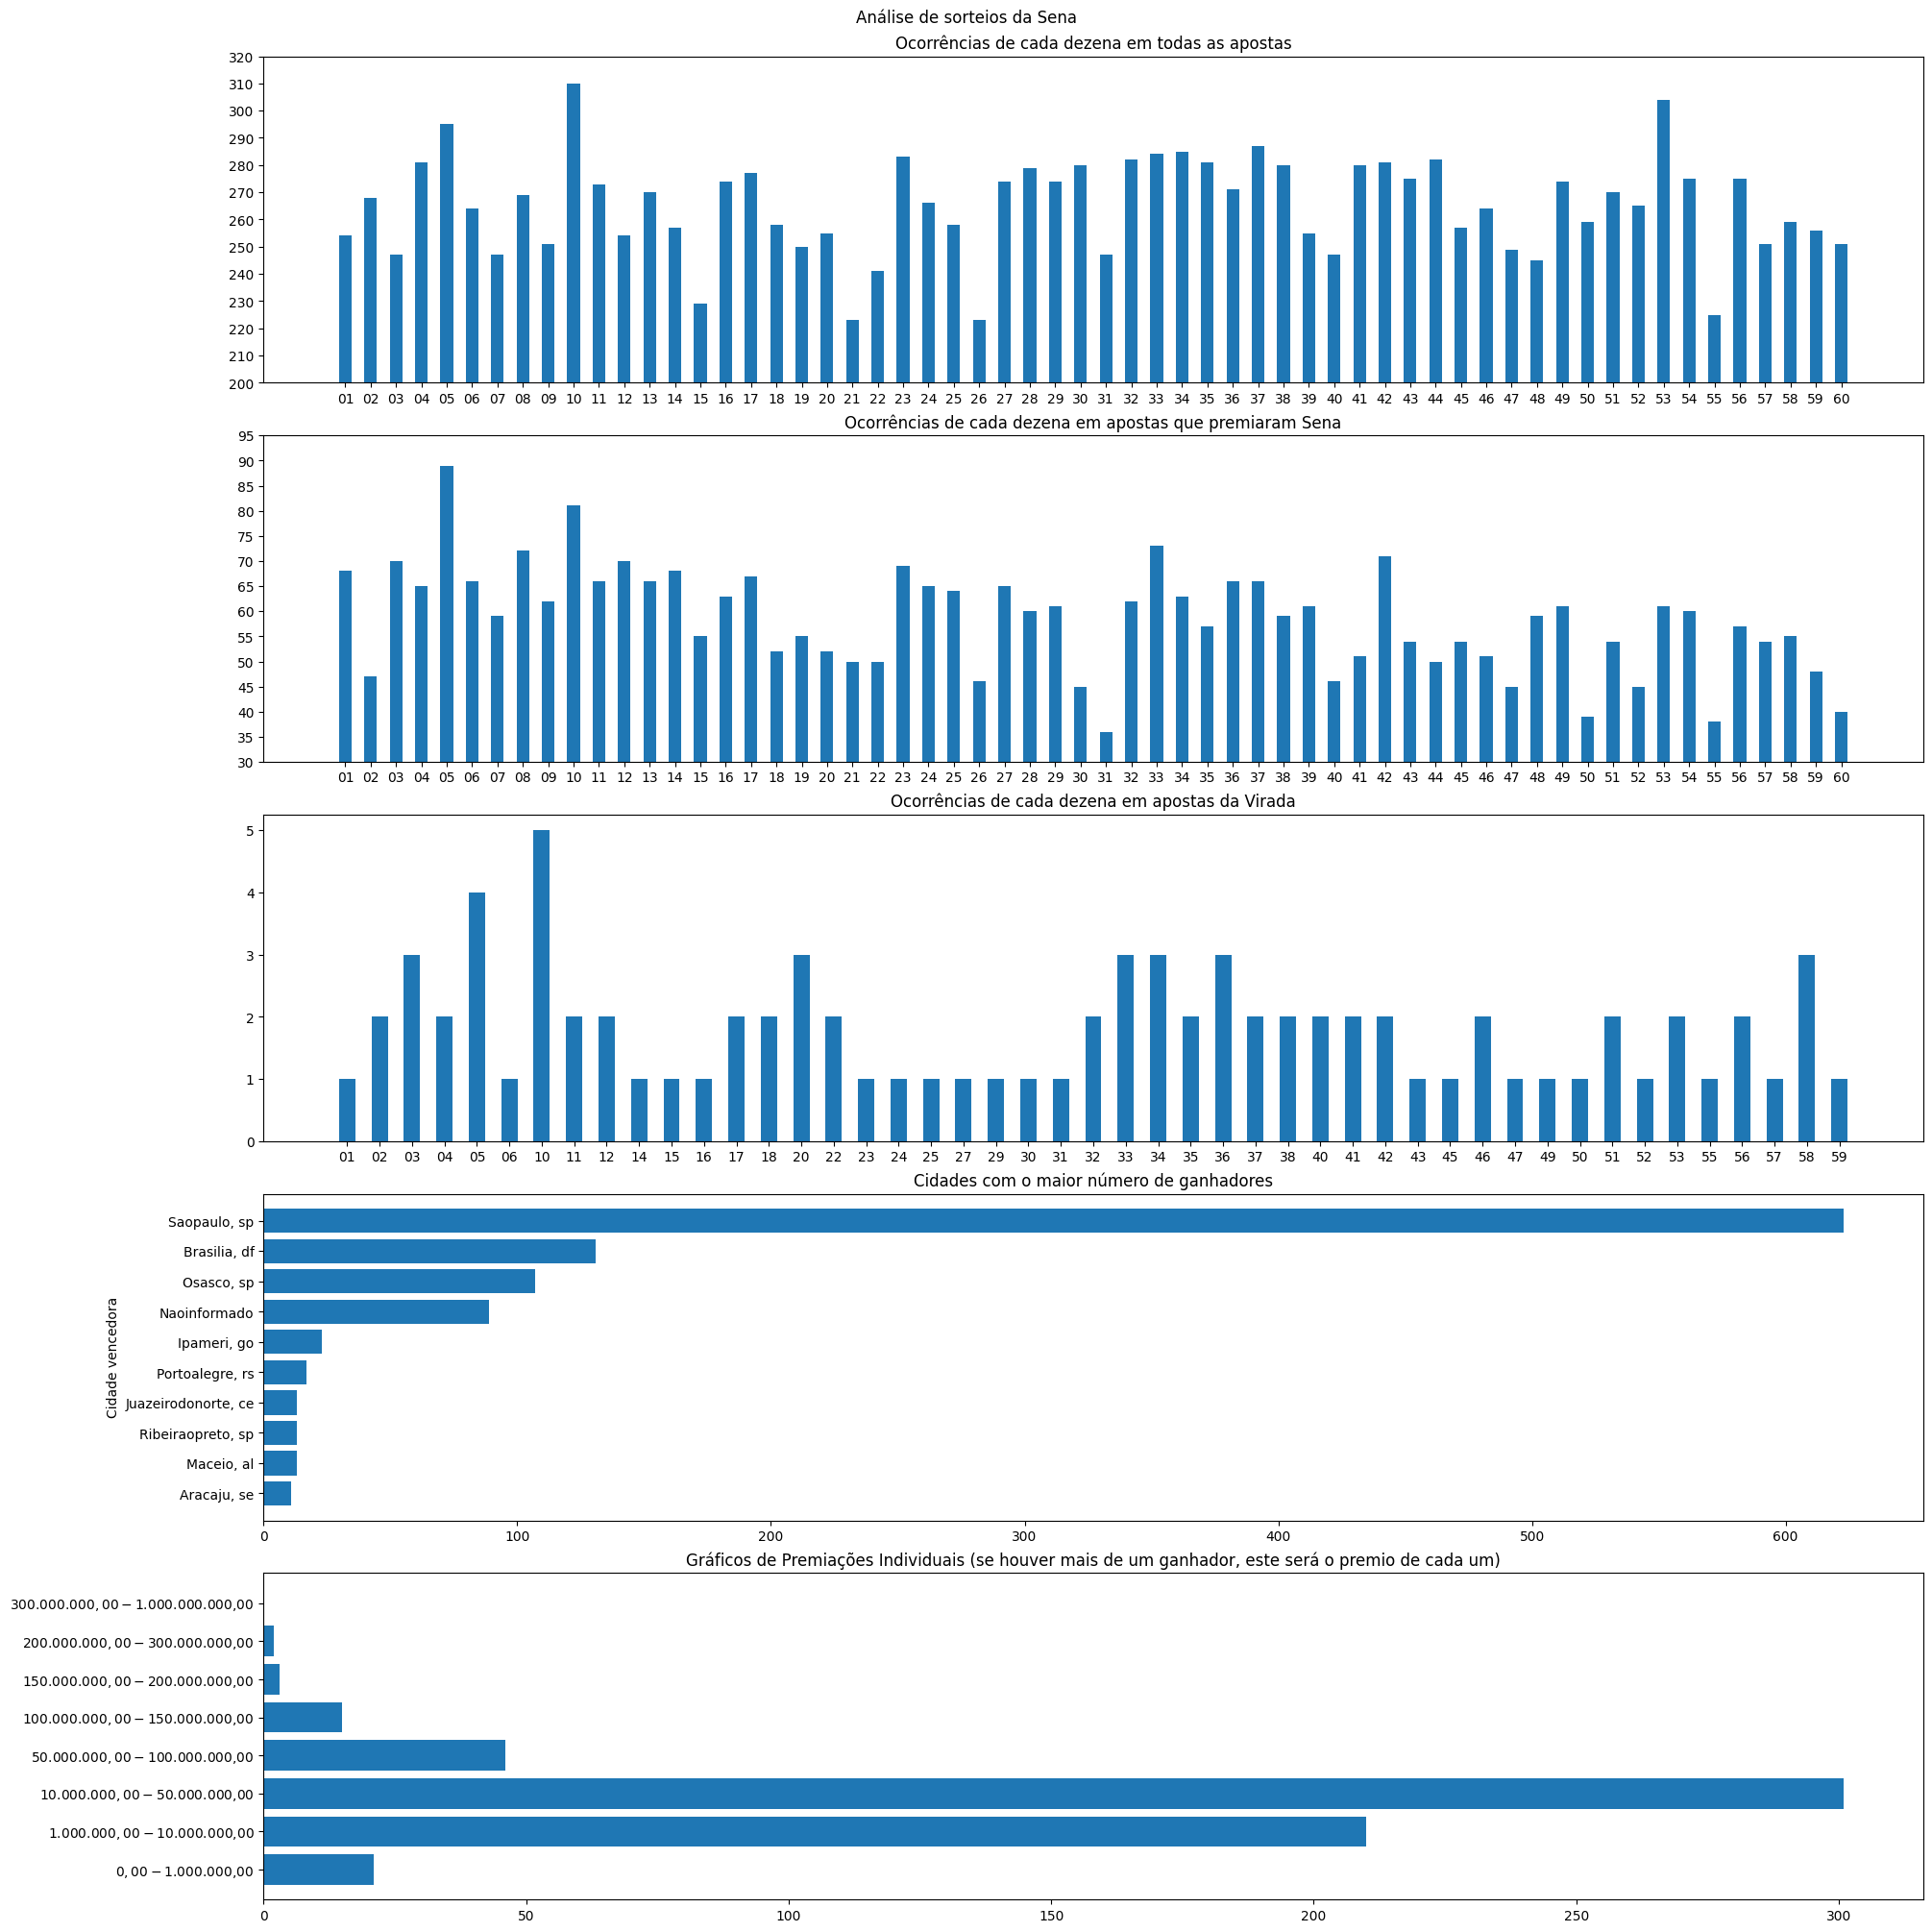

In [17]:
fgr = plt.figure(figsize=(20, 20), constrained_layout=True)
gspec = fgr.add_gridspec(nrows=5, ncols=3)
fgr.suptitle('Análise de sorteios da Sena')

# df0
ax0 = fgr.add_subplot(gspec[0, :])
ax0.bar(list(dict_dezenas), dict_dezenas.values(), width=0.5)
plt.title("Ocorrências de cada dezena em todas as apostas")
plt.yticks([i for i in range(200, 321, 10)])
plt.ylim([200, 320])

# df1
ax1 = fgr.add_subplot(gspec[1, :])
ax1.bar(list(dict_dezenas_sena), dict_dezenas_sena.values(), width=0.5)
plt.title("Ocorrências de cada dezena em apostas que premiaram Sena")
plt.yticks([i for i in range(30, 96, 5)])
plt.ylim([30, 95])

# df2
ax2 = fgr.add_subplot(gspec[2, :])
ax2.bar(list(dict_virada), dict_virada.values(), width=0.5)
plt.title("Ocorrências de cada dezena em apostas da Virada")

# df3
ax3 = fgr.add_subplot(gspec[3, :])
ax3.barh(df3.index, df3)
plt.title("Cidades com o maior número de ganhadores")
plt.ylabel("Cidade vencedora")

# df4
ax4 = fgr.add_subplot(gspec[4, :])
ax4.barh(lista_valores_locale, lista_len_dfs)
plt.title("Gráficos de Premiações Individuais (se houver mais de um ganhador, este será o premio de cada um)")

plt.show(fgr)

In [16]:
fgr.savefig("teste.png")